In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import matplotlib.style as mplstyle
import datetime


#for list of style plt.style.available (https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html)
#mplstyle.use('bmh')

In [2]:
customer_profiles_df=pd.read_csv("./data/customer_profiles_table.csv")
transactions_df=pd.read_csv("./data/transactions_df.csv")
terminal_profiles_df=pd.read_csv("./data/terminal_profiles_table.csv")

# Exploratory data analysis notebook & statistical analysis

This project will use a data set generator created by [Yann-Aël Le Borgne & Gianluca Bontempi](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html). The generator will create three dataset that reproduce the logs of a fictional card company, including fraudulent transactions. 

The logs are split in three dataset, column name in lower case are directly linked to the main dataset **transactions_df**:

1 - Customer profile

| Column | Type | Description |
| --- | --- | --- |
| CUSTOMER_ID | int64 | The customer unique ID|
|(x_customer_id,y_customer_id) | float64 | A pair of real coordinates (x_customer_id,y_customer_id) in a 100 * 100 grid, that defines the geographical location of the customer |
|(mean_amount, std_amount) | float64 | The mean and standard deviation of the transaction amounts for the customer, assuming that the transaction amounts follow a normal distribution. The mean_amount will be drawn from a uniform distribution (5,100) and the std_amount will be set as the mean_amount divided by two.|
| mean_nb_tx_per_day | float64 | The average number of transactions per day for the customer, assuming that the number of transactions per day follows a Poisson distribution. This number will be drawn from a uniform distribution (0,4) |

The generate_customer_profiles_table function provides an implementation for generating a table of customer profiles. It takes as input the number of customers for which to generate a profile and a random state for reproducibility. It returns a DataFrame containing the properties for each customer.

In [3]:
customer_profiles_df.head()

CUSTOMER_ID  x_customer_id  y_customer_id  mean_amount  std_amount  \
0            0      54.881350      71.518937    62.262521   31.131260   
1            1      42.365480      64.589411    46.570785   23.285393   
2            2      96.366276      38.344152    80.213879   40.106939   
3            3      56.804456      92.559664    11.748426    5.874213   
4            4       2.021840      83.261985    78.924891   39.462446   

   mean_nb_tx_per_day                                available_terminals  \
0            2.179533  [29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...   
1            3.567092  [5, 160, 242, 378, 431, 475, 571, 762, 876, 93...   
2            2.115580  [316, 406, 447, 523, 968, 1200, 1318, 1365, 16...   
3            0.348517  [65, 94, 113, 364, 401, 433, 485, 651, 672, 77...   
4            3.480049  [372, 614, 774, 1362, 1446, 1564, 1637, 1939, ...   

   nb_terminals  
0           767  
1           793  
2           683  
3           813  
4           594

In [4]:
customer_profiles_df.shape

(10000, 8)

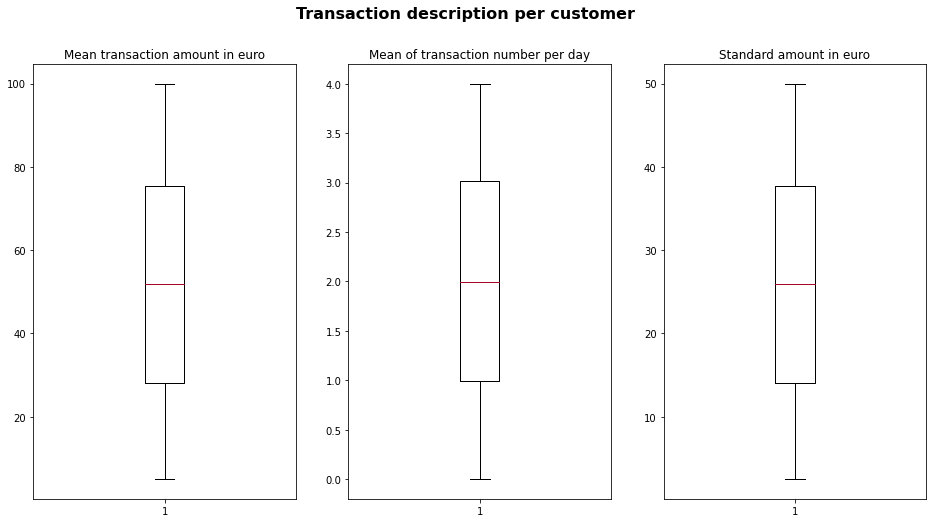

In [5]:
fig, ax = plt.subplots(1,3,figsize=(16,8))
mplstyle.use('bmh')
fig.suptitle("Transaction description per customer", fontsize=16, fontweight='bold')

ax[0].boxplot(customer_profiles_df["mean_amount"])
ax[1].boxplot(customer_profiles_df["mean_nb_tx_per_day"])
ax[2].boxplot(customer_profiles_df["std_amount"])

ax[0].title.set_text("Mean transaction amount in euro")
ax[1].title.set_text("Mean of transaction number per day")
ax[2].title.set_text("Standard amount in euro")


plt.show()

2 - Terminal profile

| Column | Type | Description |
| --- | --- | --- |
| TERMINAL_ID | int64 | The terminal ID|
| (x_terminal_id,y_terminal_id) | float64 | A pair of real coordinates (x_terminal_id,y_terminal_id) in a 100 * 100 grid, that defines the geographical location of the terminal|

The generate_terminal_profiles_table function provides an implementation for generating a table of terminal profiles. It takes as input the number of terminals for which to generate a profile and a random state for reproducibility. It returns a DataFrame containing the properties for each terminal.

In [6]:
terminal_profiles_df.head()

TERMINAL_ID  x_terminal_id  y_terminal_id
0            0      41.702200      72.032449
1            1       0.011437      30.233257
2            2      14.675589       9.233859
3            3      18.626021      34.556073
4            4      39.676747      53.881673

In [7]:
terminal_profiles_df.shape

(100000, 3)

3 - Transaction list


| Column | Type | Description |
| --- | --- | --- |
| TRANSACTION_ID  | int64 | A unique identifier for the transaction|
| TX_DATETIME  | object | Date and time at which the transaction occurs|
| CUSTOMER_ID  | int64 | The identifier for the customer. Each customer has a unique identifier|
| TERMINAL_ID  | int64 | The identifier for the merchant (or more precisely the terminal). Each terminal has a unique identifier|
| TX_AMOUNT	  | int64 | The amount of the transaction|
| TX_FRAUD  | int64 | A binary variable, with the value 0 for a legitimate transaction, or the value 1 for a fraudulent transaction|
| TX_FRAUD_SCENARIO | int64 | Referencing the fraud scenario, 0 indicate a genuine transaction|

* Fraud scenario:

Scenario 1: Any transaction whose amount is more than 220 is a fraud. This scenario is not inspired by a real-world scenario. 

Scenario 2: Every day, a list of 6 terminals is drawn at random. All transactions on these terminals in the next 28 days will be marked as fraudulent. This scenario simulates a criminal use of a terminal, through phishing for example. 

Scenario 3: Every day, a list of 6 customers is drawn at random. In the next 14 days, 1/3 of their transactions have their amounts multiplied by 5 and marked as fraudulent. This scenario simulates a card-not-present fraud where the credentials of a customer have been leaked. 

Scenario 4 : Every day a list of 4 customer is drawn at random. In the next 3 days every transaction have their amount multiplied by a random number between 3 and 6. This scenario simulate a hit and run scenario where fraudster try to exit as much funds as possible before being detected.

In [8]:
transactions_df.head()

TRANSACTION_ID          TX_DATETIME  CUSTOMER_ID  TERMINAL_ID  TX_AMOUNT  \
0               0  2018-04-01 00:00:17         6160        24605      31.83   
1               1  2018-04-01 00:00:31          596        24170      57.16   
2               2  2018-04-01 00:01:05         9339        90888      28.92   
3               3  2018-04-01 00:02:10         4961        89336      81.51   
4               4  2018-04-01 00:02:21         6170        16851      25.17   

   TX_TIME_SECONDS  TX_TIME_DAYS  TX_FRAUD  TX_FRAUD_SCENARIO  
0               17             0         0                  0  
1               31             0         0                  0  
2               65             0         0                  0  
3              130             0         0                  0  
4              141             0         0                  0

In [10]:
#Fraud repartition

transactions_df_temp = transactions_df.groupby("TX_FRAUD_SCENARIO").count()
transactions_df_temp["percentage"] = (transactions_df_temp[["TX_FRAUD"]]/
                                      transactions_df_temp[["TX_FRAUD"]].sum())*100
transactions_df_temp[["TX_FRAUD","percentage"]]

TX_FRAUD  percentage
TX_FRAUD_SCENARIO                      
0                   6940482   99.385471
1                      3825    0.054773
2                     11173    0.159994
3                     15258    0.218490
4                     12659    0.181273

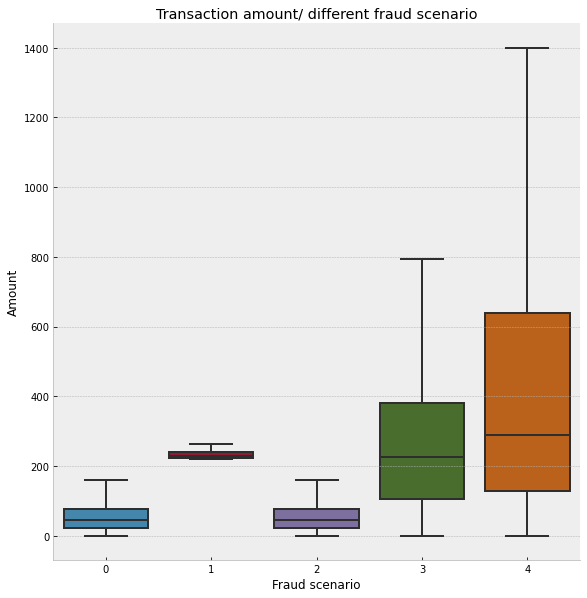

In [11]:
sns.displot(color = "rocket", height=8)

ax = sns.boxplot(x = "TX_FRAUD_SCENARIO",y = "TX_AMOUNT", data= transactions_df, showfliers = False)
ax.set_title("Transaction amount/ different fraud scenario")
ax.set_ylabel("Amount")
ax.set_xlabel("Fraud scenario");

In [ ]:
#a faire, plot time series

fig, ax=plt.subplots(1, 1, figsize=(30, 10))

ax.scatter(transactions_df, azip_pass, color="b", s=200, alpha=1.0, ec="k")

# Minor ticks every month.
fmt_day = mdates.dayLocator()

ax.xaxis.set_minor_locator(fmt_month)
# '%b' to get the names of the month
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(fmt_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# fontsize for month labels
ax.tick_params(labelsize=20, which='both')
# create a second x-axis beneath the first x-axis to show the year in YYYY format
sec_xaxis = ax.secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(fmt_year)
sec_xaxis.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Hide the second x-axis spines and ticks
sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0, labelsize=35)

plt.yticks([-180, -120, -60, 0, 60, 120, 180], ["${}^\circ$".format(x) for x in [-180, -120, -60, 0, 60, 120, 180]], fontsize=35)
plt.tight_layout()
plt.show()